In [1]:
import pytesseract
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import easyocr
import keras_ocr
import imutils
import spacy
import re
import pandas as pd
from craft_text_detector import Craft
import numpy as np
from pytesseract import Output

c:\Users\eyami\anaconda3\envs\strem_ocr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [59]:
def convert_to_300_dpi(input_image_path, output_folder, output_image_name):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Folder '{output_folder}' created.")

    # Open the image
    image = Image.open(input_image_path)
    
    # Full path to save the output image in the new folder
    output_image_path = os.path.join(output_folder, output_image_name)
    
    # Save the image with 300 DPI
    image.save(output_image_path, dpi=(300, 300))

    # Display a message indicating why 300 DPI is important for OCR
    print(f"Image saved as '{output_image_path}' with 300 DPI. "
          "This resolution is important for better OCR accuracy.")
    

image_path = r'c:\Users\eyami\OneDrive\Desktop\Financial_data_test\invoice\80234426_80234429.jpeg'
# Example usage
convert_to_300_dpi(image_path, 'processed_images', 'output_image_300dpi.png')

Image saved as 'processed_images\output_image_300dpi.png' with 300 DPI. This resolution is important for better OCR accuracy.


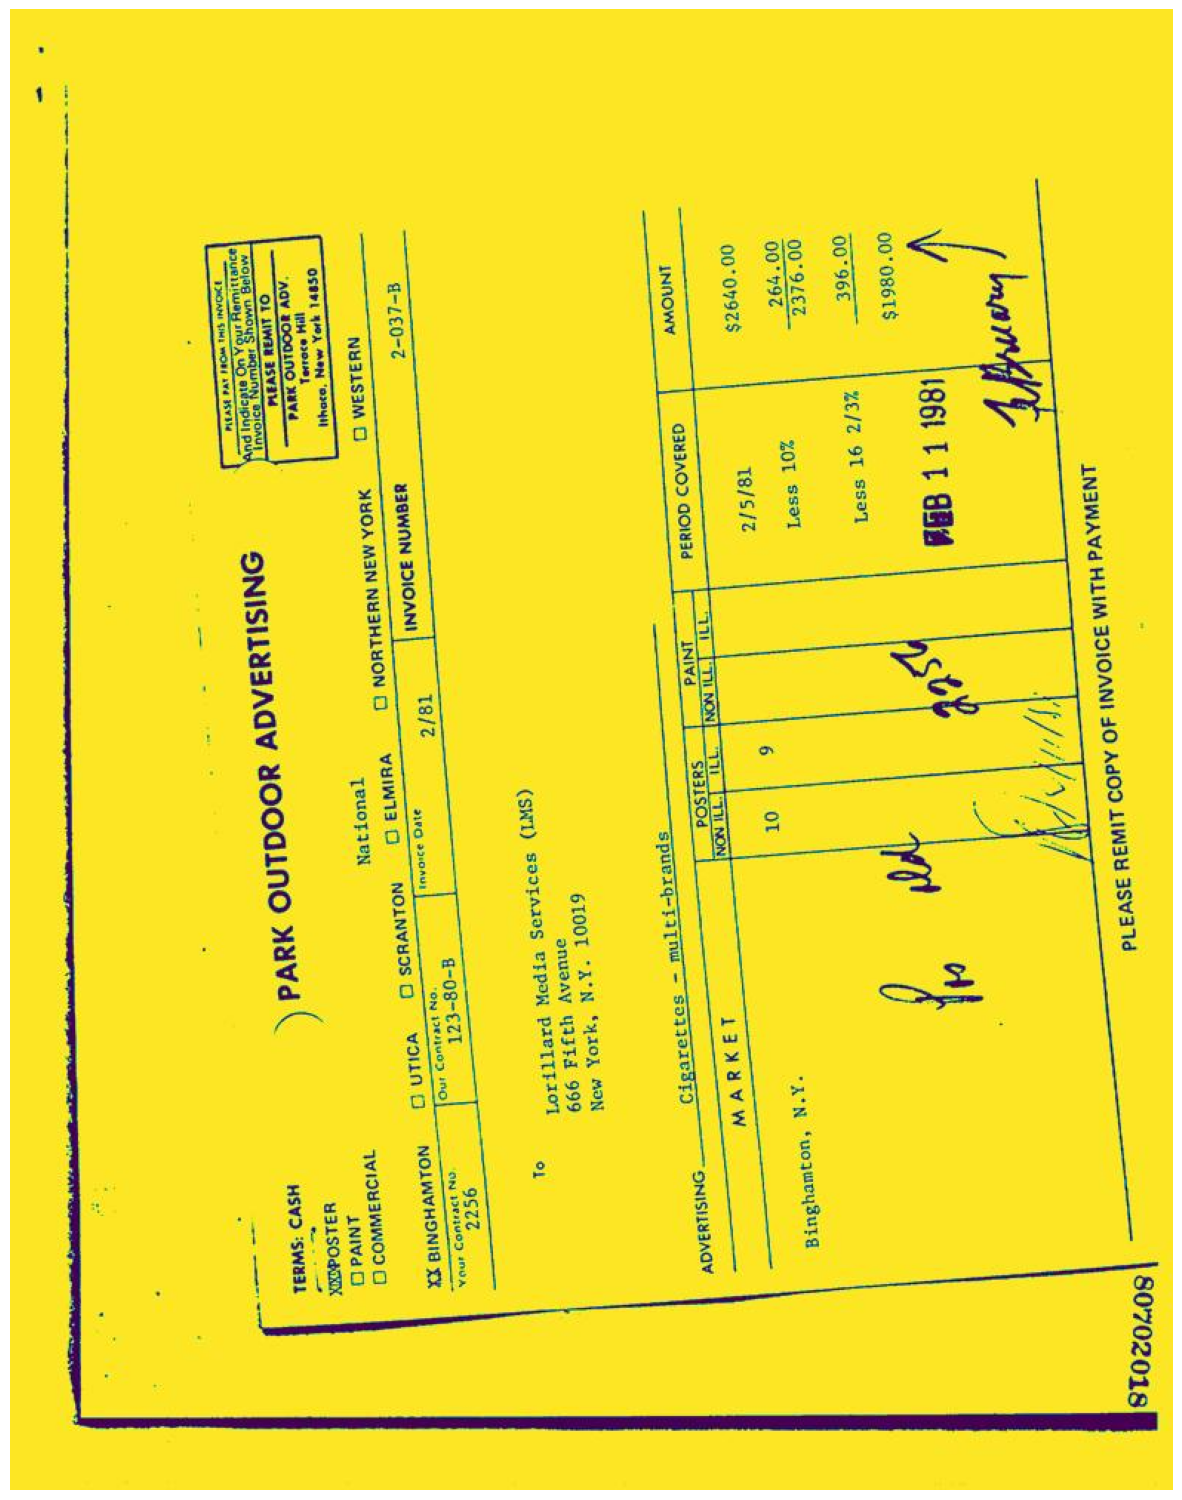

In [63]:
def display_image(image, width=10, height=8):
    """
    Displays an image using matplotlib with specified figure size.
    
    Parameters:
    - image: The image to be displayed (as a NumPy array).
    - width: The width of the figure in inches (default is 10).
    - height: The height of the figure in inches (default is 8).
    """
    # Convert the image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Set the figure size
    plt.figure(figsize=(width, height))
    
    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()

# Example usage
image_path = r'c:\Users\eyami\OneDrive\Desktop\Financial_data_test\invoice\80702018.jpeg'
# Read the image using OpenCV
image = cv2.imread(image_path) 
# Display the image with the desired size
display_image(image, width=15, height=20)  # Adjust the width and height as needed



## Pytesseract classic

In [43]:
# meth1 with pytesseract classic 
text = pytesseract.image_to_string(image,config='--psm 11')
print(text)

gis 38

|

ek

eee

{

ws

i

of

Ti

A

aan &

if

ia

if

CTR CONTRACTS 009927



## EASYOCR

In [6]:
craft_detector = Craft( crop_type="poly" , cuda = False, text_threshold=0.8, link_threshold=0.4, low_text=0.25)

c:\Users\eyami\anaconda3\envs\strem_ocr\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\eyami\anaconda3\envs\strem_ocr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\eyami\anaconda3\envs\strem_ocr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


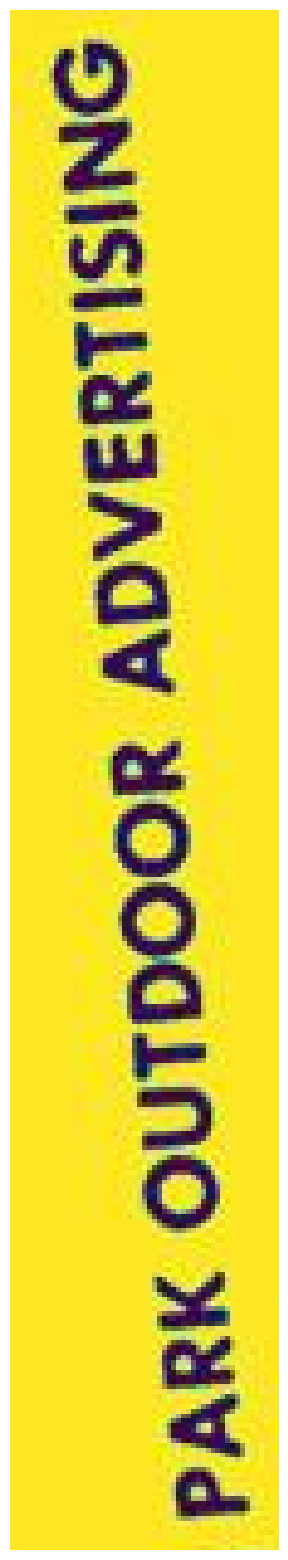

In [64]:
def detect_largest_angled_text_roi(image):
    # Create a copy of image
    img = image.copy()
    
    # Get ROIs for text using CRAFT
    text_rois = craft_detector.detect_text(img)['boxes']

    # Get angled rois
    angled_rois = []
    for roi in text_rois:
        if len(roi) >= 3:  # Ensure at least 3 points for a polygon
            # Convert box points to numpy array for easier manipulation
            box_points = np.array(roi, dtype=np.int32).reshape(-1, 2)

            # Calculate the minimum bounding rectangle
            rotated_rect = cv2.minAreaRect(box_points)
            
            # Get vertices of box 
            box_vertices = cv2.boxPoints(rotated_rect)
            box_vertices = np.int0(box_vertices)

            # Append box_vertices on angled_rois list
            angled_rois.append(box_vertices)
            
    if angled_rois:
        # Get largest roi
        largest_roi = max(angled_rois, key=cv2.contourArea)

        
        # Get the bounding box for the largest contour
        x, y, w, h = cv2.boundingRect(largest_roi)
        
        # Crop the image using the bounding box
        cropped_image = img[y:y + h, x:x + w]
        
        return cropped_image
    
    return cropped_image

# Assuming 'image' is your input image
cropped_image = detect_largest_angled_text_roi(image)

display_image(cropped_image, width=15, height=20) 


In [66]:
resized_image = cv2.resize(image, (225, 225), interpolation=cv2.INTER_LINEAR)

In [67]:
results = pytesseract.image_to_osd(cropped_image,config='--psm 0 -c min_characters_to_try=5',output_type=Output.DICT)
print(results)
# rotate the image to correct the orientation
rotated = imutils.rotate_bound(image, angle=results["rotate"])
display_image(rotated , width=15, height=20) 

TesseractError: (1, 'Estimating resolution as 1300 Too few characters. Skipping this page Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.')

In [9]:
text_reader = easyocr.Reader(['en']) #Initialzing the ocr

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [11]:
results = text_reader.readtext(rotated)
text = ""

# Iterate through the results and add each text with a newline character
for (bbox, text_segment, prob) in results:
    text += text_segment + "\n"  # Add the text and a newline

# Now `text` contains all the recognized text with line breaks
print(text) 

ITUile
403
Battelle Memorial{ Institute
OCT 2 2 1864
IN
v [ N U E
C0 L U M B U $
0 H | 0
3 2 0
October 21, 1964
ACCOUNT WmH
INyOIQ NO;
Lorfllard Conpany
35392
200,East Forty-Sacond Street
YOUR OrdER No
Nor York 17, Now
TerMs:   NET UPON PRESENIAIION OF INvOICE
FROICI No
AMOUNT
7058
Research grvice for
the month of Octobor, 1964 In
connaction
with developnent of fIltorg
to remove selactively cillastatic
copponents
fIon clgarette
soke
9,00o.00
1
York
clechmaeek
icf



In [14]:
images = [keras_ocr.tools.read('processed_images/output_image_300dpi.png')]
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = pipeline.recognize(images)

Looking for C:\Users\eyami\.keras-ocr\craft_mlt_25k.h5

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.

Looking for C:\Users\eyami\.keras-ocr\crnn_kurapan.h5
3/3 [==============================] - 5s 971ms/step


In [16]:
# Initialize a dictionary to hold lines
lines_dict = {}

# Iterate through the predictions
for predictions in prediction_groups:
    for word, box in predictions:
        # Get the vertical position (y-coordinate) of the bounding box
        y_pos = box[0][1]  # Using the first point's y-coordinate as the line's vertical position

        # Add word to the corresponding line in the dictionary
        if y_pos not in lines_dict:
            lines_dict[y_pos] = []
        lines_dict[y_pos].append(word)

# Sort the lines by their y-coordinate
sorted_lines = sorted(lines_dict.items())

# Concatenate words for each line and print
for y_pos, words in sorted_lines:
    # Joining the words for each line
    line_text = ' '.join(words)
    print(line_text)

boriston
laboratories
inc
laboratories
borriston
inc
soso
place
beech
temple hills
marland 20748
invoice
telephone
30 899 31556
telex 28688
april 124 1984
lorillarda
inc
420
engl ish street
greensboros
nc 27405
drs
attentions
harry
mi
nnemeyer
reference
purchase
order
nos 152d
bli
refs 211564

invoice
no 1564l
c
description
amount
toxicity
day
14
subacute study
in rats with
a2x a7 s 125 300 00
aos ag
oolcpd
ally a14 os2x 0500
and

addressa
remittance
laboratoriess
borri
ston
incs
dynamac
building
11140
rockville
pike
rockvilles
md 20852
subsidiary
dynamac
of international
inc
invoice


<Axes: >

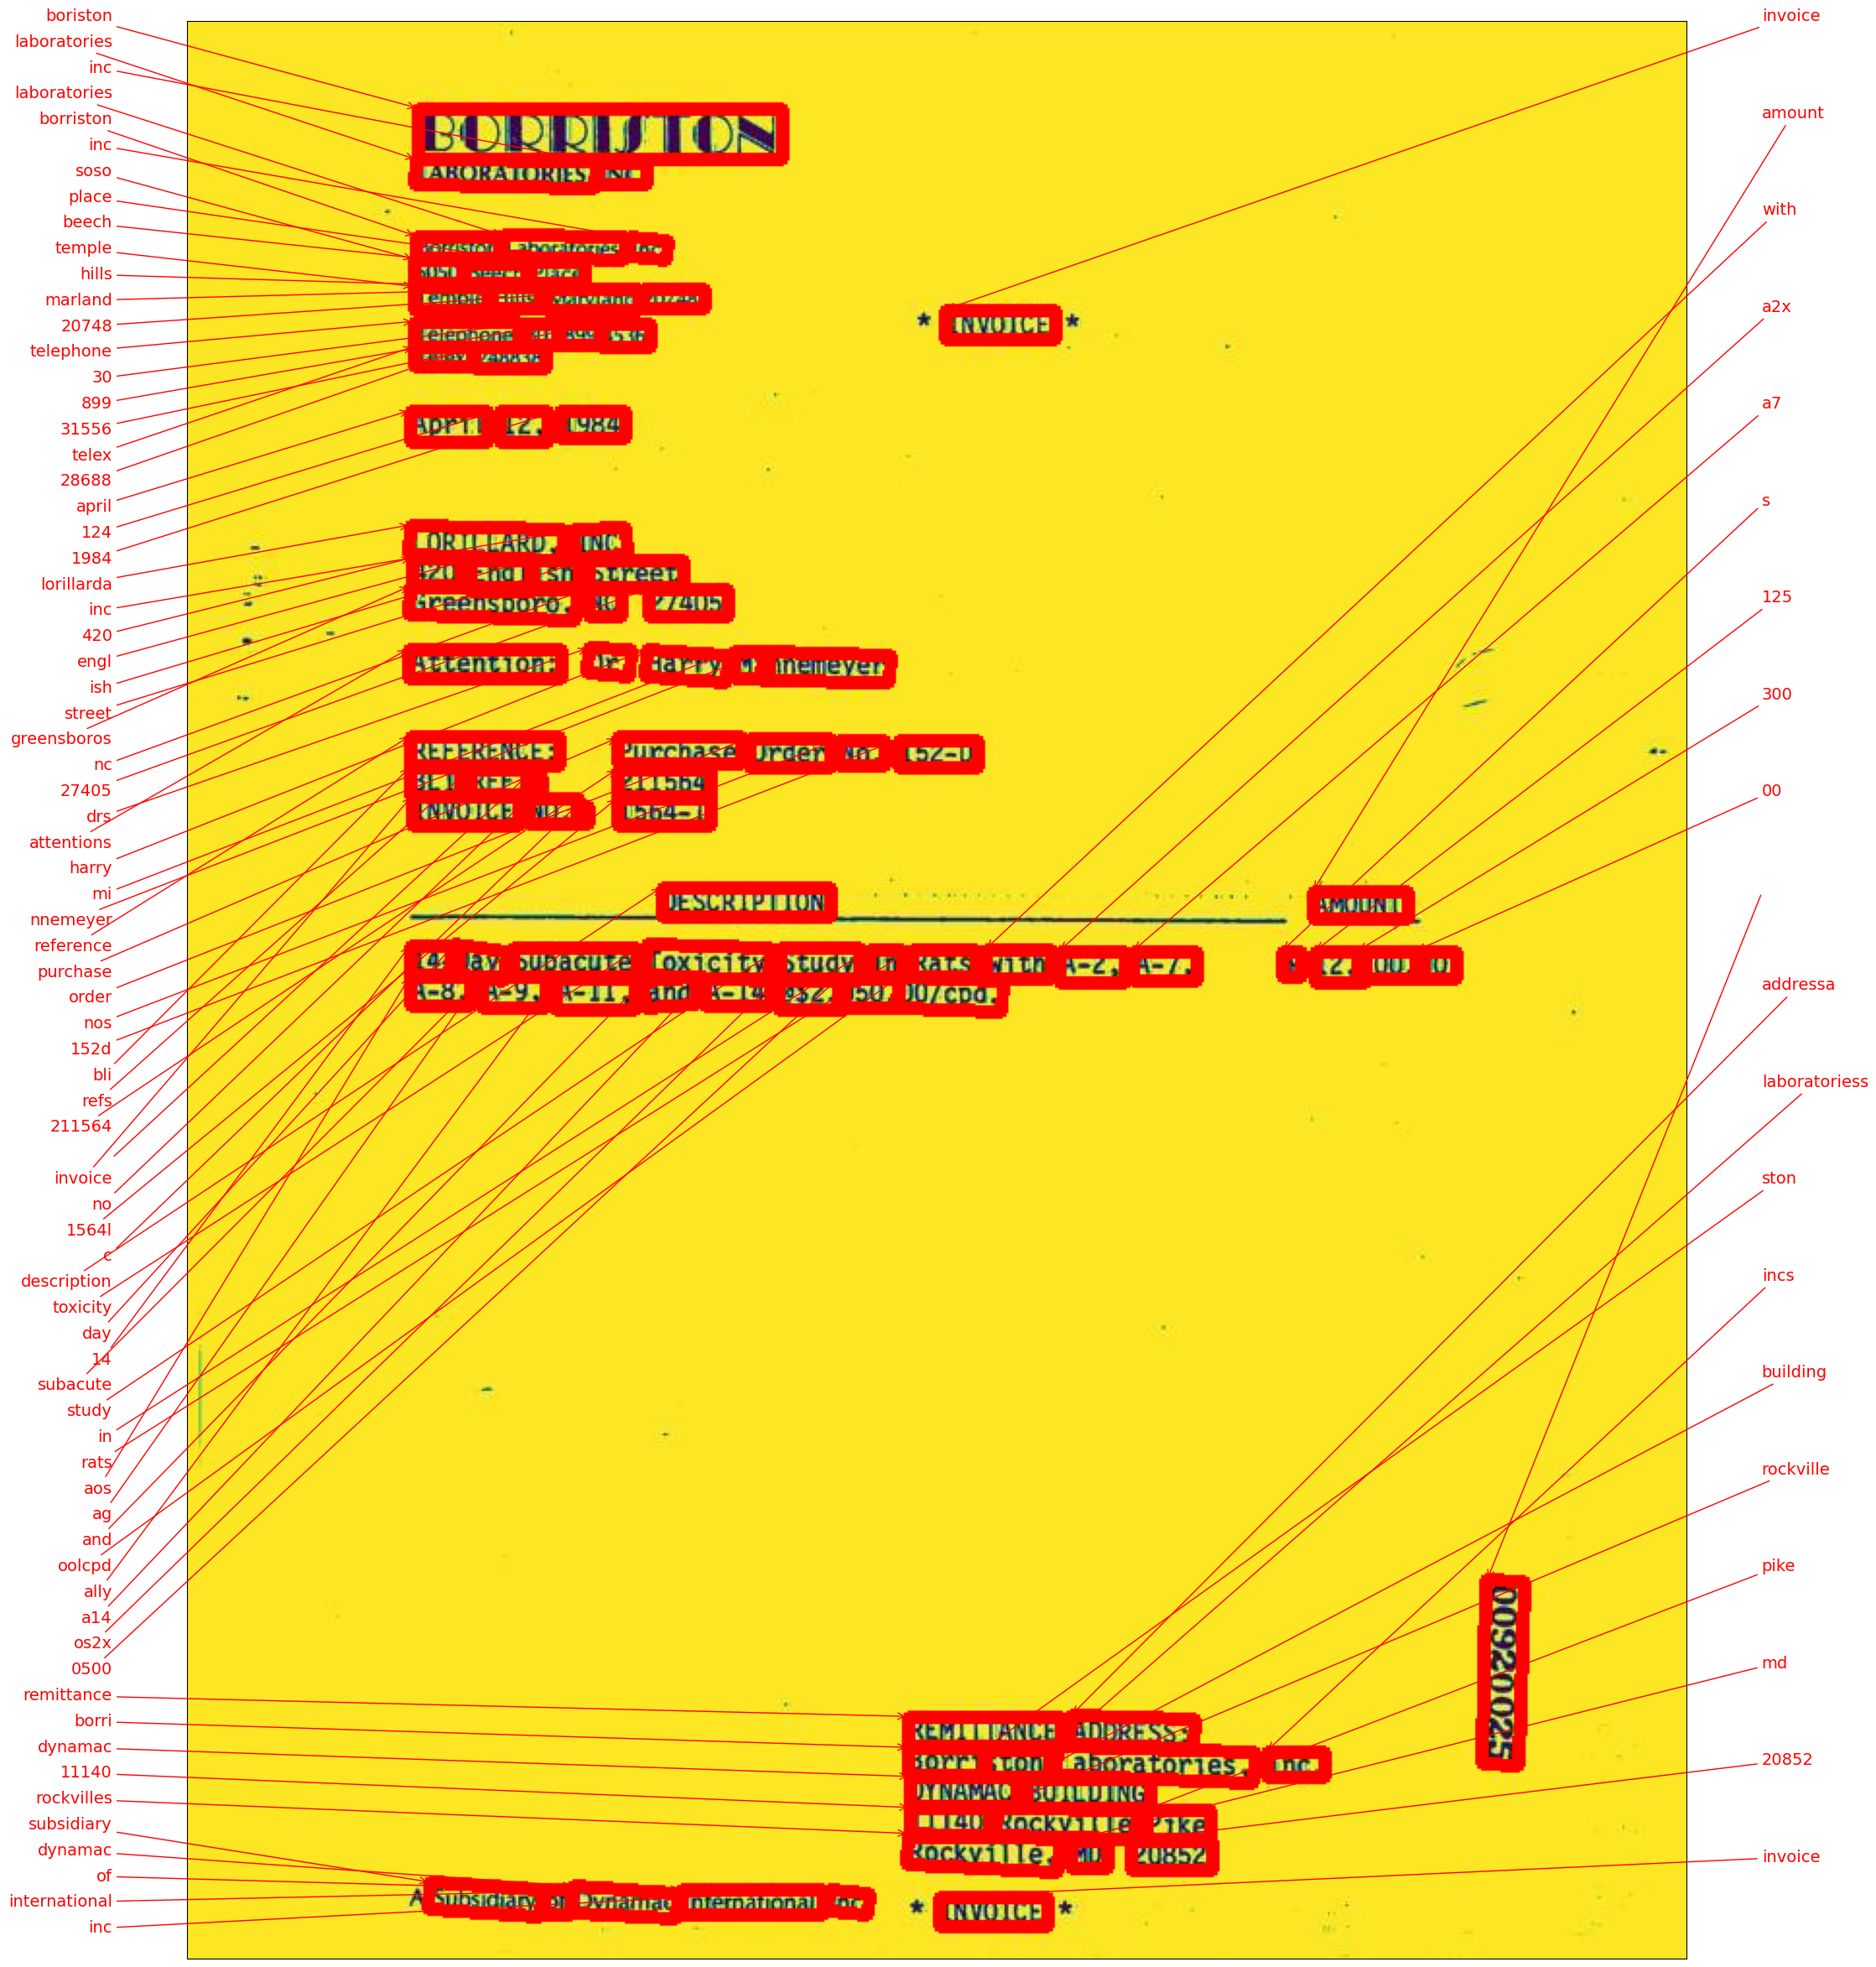

In [11]:
fig,ax= plt.subplots(nrows = 1 , figsize = (30,30))
keras_ocr.tools.drawAnnotations(images[0],prediction_groups[0], ax)

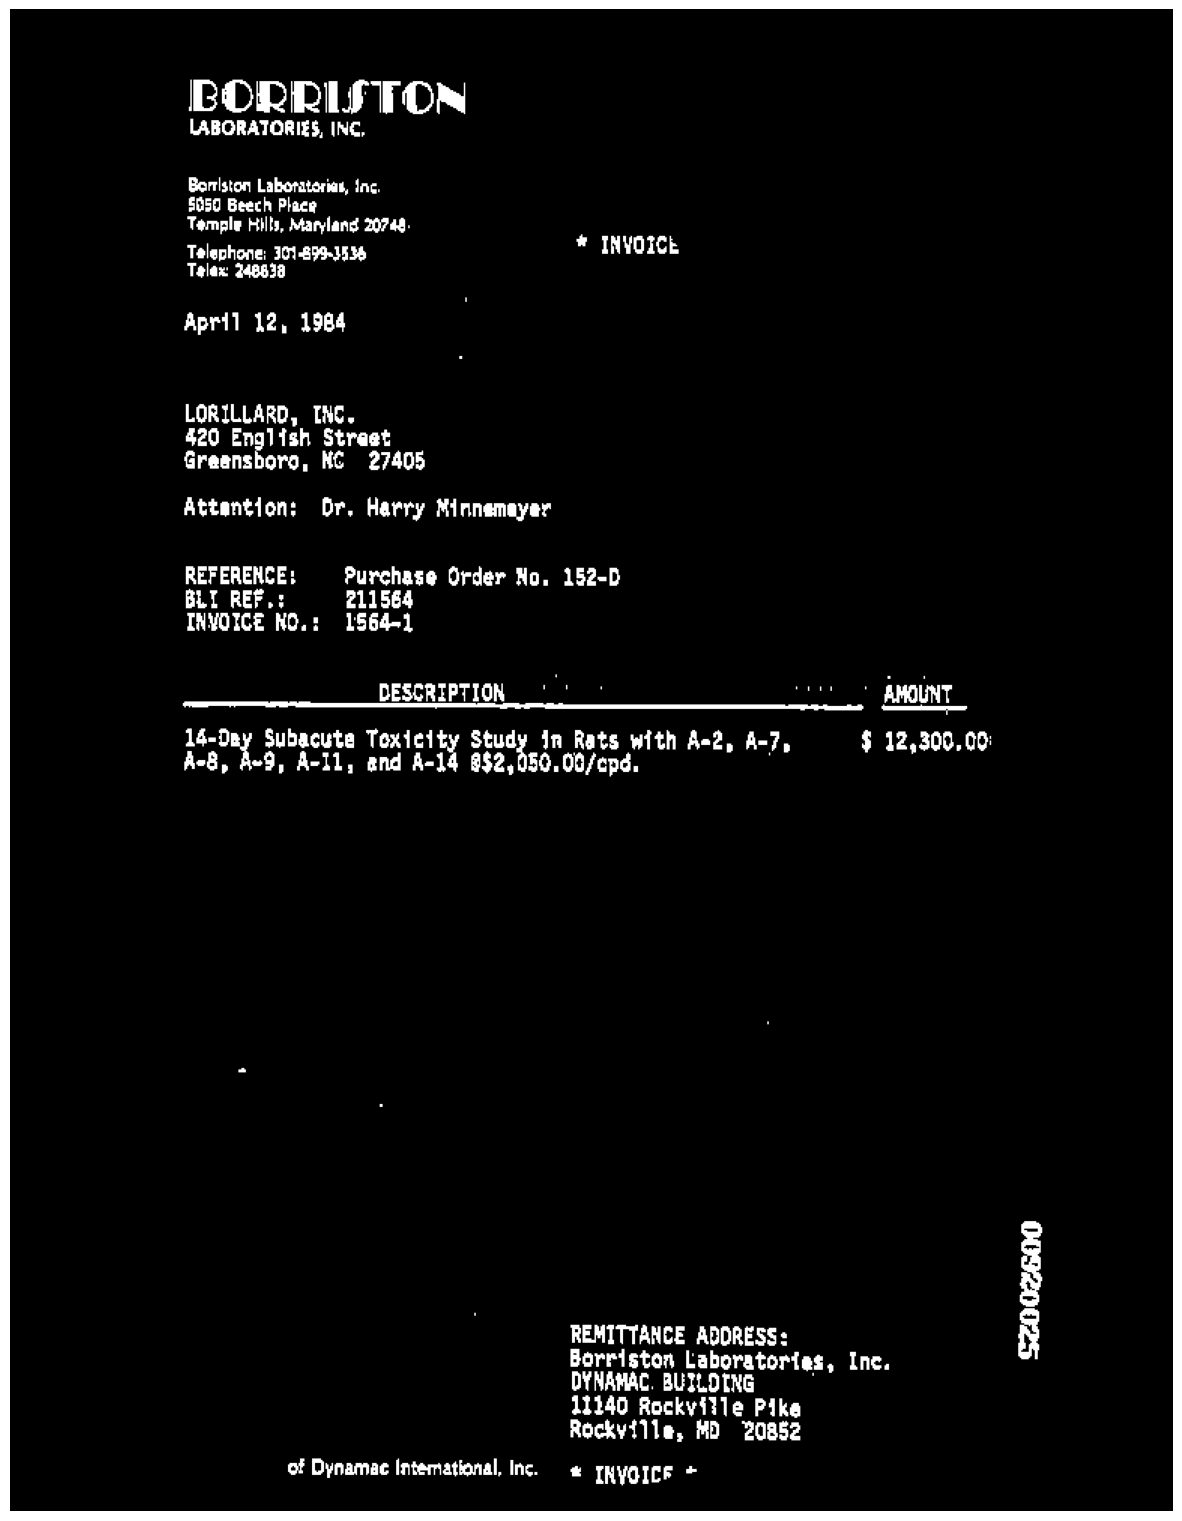

In [12]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist*255).astype('uint8')
dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
kernel1 = cv2.getStructuringElement(cv2.MORPH_CROSS, (1,1))
opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel1)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (1,2))
dilation = cv2.dilate(opening, kernel, iterations = 1)
cnts = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
nums = []
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    
    if w >= 7 and h > 10:
        nums.append(c)

nums = np.vstack([nums[i] for i in range(0, len(nums))]) #converting the list into an array
hull = cv2.convexHull(nums)
mask = np.zeros(dilation.shape[:2], dtype='uint8')
cv2.drawContours(mask, [hull], -1, 255, -1)
mask = cv2.dilate(mask, None, iterations = 2)
final = cv2.bitwise_and(dilation, dilation, mask=mask)
display_image(cv2.cvtColor(final, cv2.COLOR_BGR2RGB), width=15, height=20) 

In [13]:
text = pytesseract.image_to_string(final,config='--psm 4')
print(text)

BORRISTON

LABORATORIES, INC,

Bonlston Laboratariey, tng
5050 Beech Place
‘Temple Hils, Maryland 20748

Telephone: 301-8983536 * INVOICE
Tole 248638
April 12, 1984

LORILLARD, INC.
420 English Street
Greensboro, NC 27405

Attention: Or, Harry Xinnemayer
REFERENCE: Purchase Order No. 182-D
211564

BLY REF.:
TAVOICE KO.: 1564-1

DESCRIPTION ewe AMOUNT

14-Day Subacute Toxicity Study in Rats with Aq2, A-7, $ 12,300.00:
AeB, BoD, A-11, and A-14 8$2,050,00/epd,

REMITTANCE ADDRESS:
Borriston. Laboratories, Inc.
DYNAMAC. BUTL!

11440 ockritte Pike
Rockville, MD 20852

of Dynamac Intemational Inc. TYQICR +



## EasyOCR is the best!

In [12]:
# Load the spaCy model
nlp = spacy.load("en_core_web_trf")

def extract_earliest_date(text):
    """
    Extracts the earliest date from the given text.
    
    The function uses spaCy to find date entities in the text. 
    If no date entities are found, it falls back to regex to find 
    dates in MM/DD/YY format. If multiple dates are found, 
    it returns the earliest one.

    Args:
    text (str): The input text from which to extract dates.

    Returns:
    str: The earliest date in MM/DD/YY format or a message if no dates are found.
    """
    # Split the text into lines
    lines = text.split('\n')

    # Collect all extracted dates
    extracted_dates = []
    for line in lines:
        # Use spaCy to find date entities
        doc = nlp(line)
        date_entities = [ent.text for ent in doc.ents if ent.label_ == "DATE"]

        # If spaCy finds dates, add them to the list
        if date_entities:
            extracted_dates.extend(date_entities)
        else:
            # Use regex to find dates in MM/DD/YY format
            date_pattern = r'\b(\d{1,2}/\d{1,2}/\d{2})\b'  
            matches = re.findall(date_pattern, line)
            extracted_dates.extend(matches)  # Add regex matches to the list

    return extracted_dates 

earliest = extract_earliest_date(text)
print("Earliest date:", earliest)



c:\Users\eyami\anaconda3\envs\strem_ocr\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Earliest date: ['OCT 2 2 1864', 'October 21, 1964', 'the month of Octobor, 1964']
